In [3]:
# !pip install efficientnet_pytorch

In [4]:
!pip install pytorch-ignite

In [5]:
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import time
import tqdm
import os

from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
from efficientnet_pytorch import EfficientNet
import timm  # PyTorch Image Models (timm) 라이브러리
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
torch.cuda.empty_cache()

### 로컬환경에서 이미지 압축파일을 업로드 하기위한 코드

In [7]:
# from IPython.display import display
# from ipywidgets import FileUpload

# upload_widget = FileUpload()
# display(upload_widget)

# # 선택한 파일을 확인하려면 아래 코드를 실행하세요.
# # upload_widget.value는 딕셔너리 형태로 업로드된 파일을 반환합니다.
# for filename in upload_widget.value:
#     print(f"Uploaded file: {filename}")

# # zip 파일도 여기서 업로드할 수 있는지 확인하자

In [8]:
print(os.getcwd())

c:\Users\SBA\repository\yolo


#### 1. 이미 압축이 해제되어 있다면 압축풀기 하지않고 넘어감 
#### 2. 압축폴더안의 파일이 모두 있으면(손상되거나 분실된 것이 없다면) 넘어감
#### 3. 만약 하나라도 손상된 파일이 있으면 모두 삭제하고 재 압축해제 
#### 4. zip파일의 디렉토리 구조를 무시하고 압축해제할 수 있는 코드 추가(하위폴더가 하나 더 생겨서 추가함)

In [9]:
import os
import zipfile
import shutil

def count_files_in_dir(directory):
    """디렉토리 내의 파일 개수를 세는 함수"""
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

def extract_zip_if_needed(zip_path, extract_path, expected_file_count):
    """압축 파일을 풀기 전에 파일 수를 확인하고, 파일이 부족하면 재압축 해제"""
    if os.path.exists(extract_path):
        current_file_count = count_files_in_dir(extract_path)
        if current_file_count == expected_file_count:
            print(f"{extract_path} already has {current_file_count} files. Skipping extraction.")
            return
        else:
            print(f"{extract_path} has {current_file_count} files, expected {expected_file_count}. Re-extracting.")
            shutil.rmtree(extract_path)  # 폴더 삭제
    else:
        print(f"{extract_path} does not exist. Extracting...")

    os.makedirs(extract_path, exist_ok=True)  # 압축 풀 디렉토리 생성

    # 압축 파일 내부의 디렉토리 구조를 무시하고 파일만 추출하는 방식으로 변경
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            filename = os.path.basename(member)  # 파일 이름만 추출
            if not filename:  # 폴더는 무시
                continue
            source = zip_ref.open(member)
            target = open(os.path.join(extract_path, filename), "wb")
            with source, target:
                target.write(source.read())
    print(f"Extracted {zip_path} to {extract_path}.")

# 데이터 경로 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리
data_dir = os.path.join(base_dir, 'data')  # 'data' 폴더 생성
dog_vs_cat_zip = os.path.join(base_dir, 'dogs-vs-cats.zip')  # dogs-vs-cats.zip 파일 경로

# 1. dogs-vs-cats.zip 파일 압축 풀기
if os.path.exists(dog_vs_cat_zip):
    print(f"Extracting {dog_vs_cat_zip}...")
    with zipfile.ZipFile(dog_vs_cat_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print(f"{dog_vs_cat_zip} extracted successfully!")
else:
    print(f"{dog_vs_cat_zip} not found.")
    
# 압축 해제된 'train.zip'과 'test1.zip' 파일 경로 설정
train_data_zip = os.path.join(data_dir, 'train.zip')
test_data_zip = os.path.join(data_dir, 'test1.zip')

# 압축 해제할 디렉토리 경로 설정
train_extract_path = os.path.join(data_dir, 'train')
test_extract_path = os.path.join(data_dir, 'test1')

# 예상 파일 수 설정 (압축 파일 내부에 실제 파일 수에 맞게 설정)
expected_train_files = 25000  # train.zip 내부의 이미지 파일 수
expected_test_files = 12500  # test1.zip 내부의 이미지 파일 수

# train.zip 압축 풀기
if os.path.exists(train_data_zip):
    extract_zip_if_needed(train_data_zip, train_extract_path, expected_train_files)
else:
    print(f"{train_data_zip} not found.")

# test1.zip 압축 풀기
if os.path.exists(test_data_zip):
    extract_zip_if_needed(test_data_zip, test_extract_path, expected_test_files)
else:
    print(f"{test_data_zip} not found.")


Extracting c:\Users\SBA\repository\yolo\dogs-vs-cats.zip...
c:\Users\SBA\repository\yolo\dogs-vs-cats.zip extracted successfully!
c:\Users\SBA\repository\yolo\data\train already has 25000 files. Skipping extraction.
c:\Users\SBA\repository\yolo\data\test1 already has 12500 files. Skipping extraction.


In [10]:
import os

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: c:\Users\SBA\repository\yolo


#### 분리된 데이터를 담아둘 폴더 경로설정 및 생성

In [11]:
# 폴더명(경로)
sdata = 'sdata'
train_sdata = os.path.join(sdata, 'train')
valid_sdata = os.path.join(sdata, 'valid')
test_sdata = os.path.join(sdata, 'test')

# 폴더만들기
os.makedirs(train_sdata, exist_ok=True)
os.makedirs(valid_sdata, exist_ok=True)
os.makedirs(test_sdata, exist_ok=True)

# 하위 폴더 만들기(train)
train_sdata_dog = os.path.join(train_sdata, 'dog')
train_sdata_cat = os.path.join(train_sdata, 'cat')
os.makedirs(train_sdata_dog, exist_ok=True)
os.makedirs(train_sdata_cat, exist_ok=True)


# 하위 폴더 만들기(valid)
valid_sdata_dog = os.path.join(valid_sdata, 'dog')
valid_sdata_cat = os.path.join(valid_sdata, 'cat')
os.makedirs(valid_sdata_dog, exist_ok=True)
os.makedirs(valid_sdata_cat, exist_ok=True)


In [12]:
# 존재한다면 리스트로 만들어주기

dogList = []
catList = []

for i in range(2000):
    dogList.append('dog.'+str(i)+'.jpg')
    catList.append('cat.'+str(i)+'.jpg')

In [13]:
print(dogList)
print(catList)

['dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.5.jpg', 'dog.6.jpg', 'dog.7.jpg', 'dog.8.jpg', 'dog.9.jpg', 'dog.10.jpg', 'dog.11.jpg', 'dog.12.jpg', 'dog.13.jpg', 'dog.14.jpg', 'dog.15.jpg', 'dog.16.jpg', 'dog.17.jpg', 'dog.18.jpg', 'dog.19.jpg', 'dog.20.jpg', 'dog.21.jpg', 'dog.22.jpg', 'dog.23.jpg', 'dog.24.jpg', 'dog.25.jpg', 'dog.26.jpg', 'dog.27.jpg', 'dog.28.jpg', 'dog.29.jpg', 'dog.30.jpg', 'dog.31.jpg', 'dog.32.jpg', 'dog.33.jpg', 'dog.34.jpg', 'dog.35.jpg', 'dog.36.jpg', 'dog.37.jpg', 'dog.38.jpg', 'dog.39.jpg', 'dog.40.jpg', 'dog.41.jpg', 'dog.42.jpg', 'dog.43.jpg', 'dog.44.jpg', 'dog.45.jpg', 'dog.46.jpg', 'dog.47.jpg', 'dog.48.jpg', 'dog.49.jpg', 'dog.50.jpg', 'dog.51.jpg', 'dog.52.jpg', 'dog.53.jpg', 'dog.54.jpg', 'dog.55.jpg', 'dog.56.jpg', 'dog.57.jpg', 'dog.58.jpg', 'dog.59.jpg', 'dog.60.jpg', 'dog.61.jpg', 'dog.62.jpg', 'dog.63.jpg', 'dog.64.jpg', 'dog.65.jpg', 'dog.66.jpg', 'dog.67.jpg', 'dog.68.jpg', 'dog.69.jpg', 'dog.70.jpg', 'dog.71.jpg', '

#### 시드함수추가

In [14]:
import random
import numpy as np

# 시드 설정 함수 정의
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 여러 GPU 사용 시
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 설정
set_seed(42)

### train/valid/test split 일반화

In [15]:
# 데이터셋의 총 개수를 인자로 받아 비율에 따라 분할
def split_data(total_num, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    # 비율의 합이 1인지 확인
    assert train_ratio + valid_ratio + test_ratio == 1.0, "비율의 합은 1이어야 합니다."

    # 각 데이터셋의 개수 계산
    train_num = int(total_num * train_ratio)
    valid_num = int(total_num * valid_ratio)
    test_num = total_num - train_num - valid_num  # 남은 데이터를 테스트셋으로

    # 각 데이터셋의 범위 계산
    train_range = [0, train_num - 1]
    valid_range = [train_num, train_num + valid_num - 1]
    test_range = [train_num + valid_num, total_num - 1]

    return train_range, valid_range, test_range

# 예시: 총 데이터 개수가 12500일 경우
total_num = 12500
train_range, valid_range, test_range = split_data(total_num)

print(f"Train range: {train_range}")
print(f"Valid range: {valid_range}")
print(f"Test range: {test_range}")

Train range: [0, 9999]
Valid range: [10000, 11249]
Test range: [11250, 12499]


#### test 데이터를 더이상 train data에서 split 하지 않고 기존 testdata에서 가져오고 싶으면 복사할때 경로만 수정해주면 된다.

In [16]:
import os
import shutil

# 데이터셋 디렉토리 경로 설정 (데이터셋이 저장된 경로로 수정하세요)
# train_dataset_dir = 'train'
# test_data_dir = 'test1'
# test = 'sdata/test'
dataset_dir = 'data/train'
test_dataset_dir = 'data/test1'

# 새로운 train, valid, test 디렉토리 생성 경로
base_dir = 'sdata'

# 클래스 목록
classes = ['dog', 'cat']

# 폴더 경로 생성
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 폴더 생성 함수
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# train, valid, test 폴더 및 각각의 클래스 폴더 생성
for cls in classes:
    create_dir(os.path.join(train_dir, cls))
    create_dir(os.path.join(valid_dir, cls))
    create_dir(os.path.join(test_dir))

# 이미지 복사 함수
def copy_images(start_idx, end_idx, src_dir, dst_dir, label):
    for i in range(start_idx, end_idx + 1):
        file_name = f'{label}.{i}.jpg'
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        if os.path.exists(src_path):
            # print(f"Copying {src_path} to {dst_path}")
            shutil.copy(src_path, dst_path)
        # else:
            # print(f"File not found: {src_path}")

# 클래스별로 train, valid, test 데이터셋 구성
for cls in classes:
    # train dataset 구성
    copy_images(train_range[0], train_range[1], dataset_dir, os.path.join(train_dir, cls), cls)

    # valid dataset 구성
    copy_images(valid_range[0], valid_range[1], dataset_dir, os.path.join(valid_dir, cls), cls)

    # test dataset 구성(train dataset에서 test data 분할한 경우)
    copy_images(test_range[0], test_range[1], dataset_dir, os.path.join(test_dir), cls)

# # test dataset 구성 (진짜 test 폴더의 모든 파일 복사)
# test_files = os.listdir(test_dataset_dir)

# # test_files에서 0번째부터 1249번째 파일만 선택
# for idx, file_name in enumerate(test_files):
#     src_path = os.path.join(test_dataset_dir, file_name)
#     dst_path = os.path.join(test_dir, file_name)

#     if os.path.exists(src_path):
#         shutil.copy(src_path, dst_path)
#     else:
#         print(f"File not found: {src_path}")
print("데이터셋 분할 및 복사가 완료되었습니다.")

데이터셋 분할 및 복사가 완료되었습니다.


In [17]:
test_dir

'sdata\\test'

In [18]:
test = 'sdata/test'
file_list = os.listdir(test_dir)
print(f"파일 개수: {len(file_list)}")

파일 개수: 2500


In [19]:
train_cat = os.listdir(os.path.join(train_dir,'cat'))
train_dog = os.listdir(os.path.join(train_dir,'dog'))
valid_cat = os.listdir(os.path.join(valid_dir,'cat'))
valid_dog = os.listdir(os.path.join(valid_dir,'dog'))
test = os.listdir(test_dir)

In [20]:
len(train_cat), len(train_dog), len(valid_cat), len(valid_dog), len(test)

(10000, 10000, 1250, 1250, 2500)

### 테스트 데이터에 따른 2가지 커스텀 데이터셋 정의

레이블이 없는 테스트 데이터 가져올때

In [21]:
# # # 4. Custom Dataset 정의
# class customDataset(Dataset):
#     def __init__(self, files, root_dir, mode, transform=None):
#         self.files = files
#         self.root_dir = root_dir
#         self.mode = mode
#         self.transform = transform

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root_dir, self.files[idx])
#         img = Image.open(img_path)

#         # 레이블 설정: 파일명에 따라 동적으로 레이블 설정
#         if 'dog' in self.files[idx]:
#             label = 1
#         else:
#             label = 0

#         if self.transform:
#             img = self.transform(img)

#         # 'train' 모드일 때는 이미지와 레이블만 반환
#         if self.mode == 'train':
#             return img, np.array([label])

#         # 'test' 모드일 때는 이미지, 레이블, 파일 이름을 반환
#         else:
#             return img, self.files[idx]

train data에서 test data까지 split 했다면 test data에도 lable이 존재하므로 아래의 코드를 활용가능

In [22]:
class customDataset(Dataset):
    def __init__(self, files, root_dir, mode, transform=None):
        self.files = files
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        # 레이블 생성 cat=0, dog=1
        if 'dog' in files[0]:
            self.label = 1
        else:
            self.label = 0
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        if self.mode == 'train':
            return img, np.array([self.label])

        else:
            if self.files[idx].split('.')[0]=='dog':
                self.label = 1
            else:
                self.label = 0
            return img, np.array([self.label]), self.files[idx]

#### 이미지 전처리

In [23]:
# 5. 이미지 전처리 설정
org_size = (256, 256)
img_size = 224
visual_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    # 평균이 0.5 표준편차 0.5 (0~1사이의 실수)
    transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### 데이터셋 인스턴스화

In [24]:
# 데이터셋 인스턴스화

# 인수값 : 파일목록, 파일경로, 모드, transforms


visual_dog_dataset = customDataset(train_dog, os.path.join(train_dir, 'dog'), 'train', transform=visual_transform)
visual_cat_dataset = customDataset(train_cat, os.path.join(train_dir, 'cat'), 'train', transform=visual_transform)

train_dog_dataset = customDataset(train_dog, os.path.join(train_dir,'dog'), 'train', transform = train_transform)
train_cat_dataset = customDataset(train_cat, os.path.join(train_dir,'cat'), 'train', transform = train_transform)

# valid 데이터도 레이블이 필요하기 때문에 train 모드로 받아와야 함
valid_dog_dataset = customDataset(valid_dog, os.path.join(valid_dir,'dog'), 'train', transform = train_transform)
valid_cat_dataset = customDataset(valid_cat, os.path.join(valid_dir,'cat'), 'train', transform = train_transform)

# 테스트데이터 가져오기
test_dataset = customDataset(test, os.path.join(test_dir), 'test', transform = test_transform)


from torch.utils.data import ConcatDataset
visual_dataset = ConcatDataset([visual_dog_dataset, visual_cat_dataset])
train_dataset = ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = ConcatDataset([valid_dog_dataset, valid_cat_dataset])


#### 데이터로더 인스턴스화

In [25]:
# 데이터로더 객체생성

from torch.utils.data import DataLoader

batch_size = 16
visual_loader = DataLoader(visual_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#### 가져올 데이터 시각화

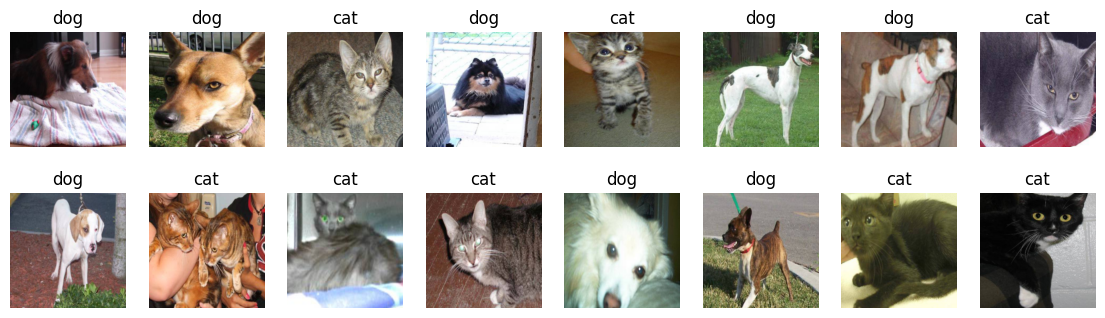

In [26]:
import matplotlib.pyplot as plt

# 배치사이즈만큼의 이미지를 시각화함함
images, labels = next(iter(visual_loader))

classes ={0:'cat',1:'dog'}

fig = plt.figure(figsize=(14, 8))
for i in range(batch_size):
    # 4행 8열
    ax = fig.add_subplot(4, 8, i + 1)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    # 컬러 채널 순서를 재정렬
    ax.imshow(images[i].permute(1, 2, 0))

plt.show()

#### 모델 정의 및 설정

In [27]:
import torch
import torch.nn as nn
import torchvision
from efficientnet_pytorch import EfficientNet

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# He 초기화를 적용하는 함수 정의
def initialize_weights_he(module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

# 모델 정의 및 수정
def create_model(model_name):
    """모델 생성 및 수정"""
    if model_name == 'efficientNetB2':
        model = EfficientNet.from_pretrained('efficientnet-b2')
    elif model_name == 'efficientNetB0':
        model = EfficientNet.from_pretrained('efficientnet-b0')
    elif model_name == 'MNV3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
    elif model_name == 'MNV3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
    elif model_name == 'RESNET50':
        model = torchvision.models.resnet50(pretrained=True)
    else:
        raise ValueError(f"Model '{model_name}' not recognized.")
    
    
    # 모델의 특징 추출기(frozen)를 고정시키기
    for param in model.parameters():
        param.requires_grad = False  # 모든 파라미터 고정
        
    # GPU로 모델 이동
    model = model.to(device)

    # 모델에 따라 마지막 레이어 수정
    if model_name in ['efficientNetB2', 'efficientNetB0']:
        # EfficientNet 모델의 마지막 레이어 수정
        num_features = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 이진 분류용 Sigmoid
        ).to(device)
        # He 초기화 적용
        model._fc.apply(initialize_weights_he)
    
    elif model_name in ['MNV3_large', 'MNV3_small']:
        # MobileNet V3의 마지막 레이어 수정
        num_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)
        # He 초기화 적용
        model.classifier.apply(initialize_weights_he)
    
    elif model_name == 'RESNET50':
        # ResNet의 마지막 레이어 수정
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)
        # He 초기화 적용
        model.fc.apply(initialize_weights_he)

    return model

# 선택 가능한 모델 출력
models = ['efficientNetB2', 'efficientNetB0', 'MNV3_large', 'MNV3_small', 'RESNET50']
print("사용 가능한 모델:")
for model_name in models:
    print(f" - {model_name}")

# 모델 선택
selected_model_name = "MNV3_small"  # 선택하려는 모델 이름

# 모델 생성
model = create_model(selected_model_name)
print(f"선택된 모델: {selected_model_name}")

사용 가능한 모델:
 - efficientNetB2
 - efficientNetB0
 - MNV3_large
 - MNV3_small
 - RESNET50


c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


선택된 모델: MNV3_small


In [28]:
import torch
import torch.nn as nn
import torchvision
from efficientnet_pytorch import EfficientNet

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# He 초기화를 적용하는 함수 정의
def initialize_weights_he(module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

# 분류기 레이어를 수정하는 함수 정의
def modify_classifier(model, num_features, model_name):
    """모델의 분류기 레이어를 수정하고 He 초기화를 적용하는 함수"""
    classifier = nn.Sequential(
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 1),
        nn.Sigmoid()  # 이진 분류용 Sigmoid
    ).to(device)
    
    # He 초기화 적용
    classifier.apply(initialize_weights_he)
    
    # 분류기 레이어에 학습 가능하도록 requires_grad 설정
    for param in classifier.parameters():
        param.requires_grad = True

    # 모델의 분류기 부분을 교체
    if model_name in ['efficientNetB2', 'efficientNetB0']:
        model._fc = classifier
    elif model_name in ['MNV3_large', 'MNV3_small']:
        model.classifier = classifier
    elif model_name == 'RESNET50':
        model.fc = classifier

    return model

# 모델 생성 및 수정 함수
def create_model(model_name):
    """모델 생성 및 수정"""
    if model_name == 'efficientNetB2':
        model = EfficientNet.from_pretrained('efficientnet-b2')
        num_features = model._fc.in_features
    elif model_name == 'efficientNetB0':
        model = EfficientNet.from_pretrained('efficientnet-b0')
        num_features = model._fc.in_features
    elif model_name == 'MNV3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
        num_features = model.classifier[0].in_features
    elif model_name == 'MNV3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = model.classifier[0].in_features
    elif model_name == 'RESNET50':
        model = torchvision.models.resnet50(pretrained=True)
        num_features = model.fc.in_features
    else:
        raise ValueError(f"Model '{model_name}' not recognized.")
    
    # 모든 파라미터 고정
    for param in model.parameters():
        param.requires_grad = False

    # 분류기 레이어 수정 및 학습 가능하게 설정
    model = modify_classifier(model, num_features, model_name)

    # 모델을 GPU로 이동
    model = model.to(device)

    return model

# 선택 가능한 모델 출력
models = ['efficientNetB2', 'efficientNetB0', 'MNV3_large', 'MNV3_small', 'RESNET50']
print("사용 가능한 모델:")
for model_name in models:
    print(f" - {model_name}")

# 모델 선택
selected_model_name = "efficientNetB0"  # 선택하려는 모델 이름

# 모델 생성
model = create_model(selected_model_name)
print(f"선택된 모델: {selected_model_name}")

사용 가능한 모델:
 - efficientNetB2
 - efficientNetB0
 - MNV3_large
 - MNV3_small
 - RESNET50
Loaded pretrained weights for efficientnet-b0
선택된 모델: efficientNetB0


#### timm 라이브러리를 활용하여 모델을 불러옴

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# EfficientNetV2B0 모델 불러오기 (timm 라이브러리 사용)
model = timm.create_model('efficientnet_b0', pretrained=True)

# EfficientNet-B0의 특징 추출기(frozen)를 고정시키기
for param in model.parameters():
    param.requires_grad = False  # 모든 파라미터 고정

# 마지막 레이어의 입력 특징 수를 가져옵니다.
num_features = model.classifier.in_features

# 이진 분류를 위한 새로운 분류기 추가 (마지막 레이어 수정)
model.classifier = nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
)

# 분류기 부분만 학습되도록 파라미터 업데이트 설정
for param in model.classifier.parameters():
    param.requires_grad = True  # 분류기 부분만 학습 가능하게 설정

# 모델을 GPU 또는 CPU에 할당
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [30]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# EfficientNetV2B0 모델 불러오기 (timm 라이브러리 사용)
model = timm.create_model('efficientnet_b0', pretrained=True)
selected_model_name = 'efficientnet_b0'

# 마지막 레이어의 입력 특징 수를 가져옵니다.
num_features = model.classifier.in_features

# 이진 분류를 위한 새로운 분류기 추가 (마지막 레이어 수정)
model.classifier = nn.Sequential(
    nn.Linear(num_features, 1),  # 출력 노드를 1개로 설정 (이진 분류)
    nn.Sigmoid()  # Sigmoid 활성화 함수 추가
)

# 모델을 GPU 또는 CPU에 할당
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [31]:
# EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): 성능 개선이 없을 때 몇 번의 에포크까지 기다릴지.
            verbose (bool): True일 경우 개선될 때마다 메시지 출력.
            delta (float): 성능 개선으로 간주될 최소 변화량.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        # 처음에 호출됐을때는 best_score가 None이라서 초기값을 설정
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # 지금까지의 best_scor
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''검증 손실이 감소하면 모델을 저장합니다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), self.path)  # 모델 상태 저장
        self.val_loss_min = val_loss

In [32]:
from torchsummary import summary
summary(model, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
          Identity-2         [-1, 32, 128, 128]               0
              SiLU-3         [-1, 32, 128, 128]               0
    BatchNormAct2d-4         [-1, 32, 128, 128]              64
            Conv2d-5         [-1, 32, 128, 128]             288
          Identity-6         [-1, 32, 128, 128]               0
              SiLU-7         [-1, 32, 128, 128]               0
    BatchNormAct2d-8         [-1, 32, 128, 128]              64
          Identity-9         [-1, 32, 128, 128]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
    SqueezeExcite-14         [-1, 32, 1

#### 손실함수 및 옵티마이저 정의(하이퍼파라미터 튜닝)

In [33]:
# 7. 손실함수 및 옵티마이저 정의
lr = 0.01
epochs = 15
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 학습률 조정(loss를 기준으로 한다면 mode가 min/ accuracy를 기준으로 한다면 max로 수정한다.)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience = 3)

# EarlyStopping 인스턴스 생성 (patience=10)
path = f"{selected_model_name}_best.pth"
early_stopping = EarlyStopping(patience=10, verbose=True, path=path)

#### fit 함수 정의

In [34]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def imshow(img):
    # 이미지 정규화를 해제하기 위해 역변환
    img = img / 2 + 0.5  # (0.5, 0.5, 0.5)로 정규화된 이미지일 경우
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    # 훈련 시작시 초기 lr을 로딩
    pre_lr = optimizer.param_groups[0]['lr']
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    # 그래프를 출력하기 위해 리스트에 누적
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # 잘못 예측된 이미지를 저장할 리스트
    wrong_images = []
    wrong_labels = []
    wrong_preds = []

    for epoch in range(epochs):
        start = time.time()

        # tqdm을 사용하여 각 에포크의 진행률 표시
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        # 1 epoch 중에 train에 해당하는 for 문
        for train_x, train_y in train_loader_tqdm:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            # 기울기 초기화
            optimizer.zero_grad()
            # 예측
            pred = model(train_x)
            # 손실계산
            loss = criterion(pred, train_y)
            # 오차역전파
            loss.backward()
            # 진행
            optimizer.step()
            train_loss += loss.item()

            # sigmoid
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            # y_pred와 train_y값이 같으면 train_correct 추가
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        # tqdm을 사용하여 각 에포크의 validation 진행률 표시
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        # 1 epoch 중에 validation에 해당하는 for 문
        for valid_x, valid_y in valid_loader_tqdm:
            with torch.no_grad():
                model.eval()
                # print(f'valid_x : {valid_x}')
                # print(f'type(valid_x) : {type(valid_x)}')
                # print(f'valid_y : {valid_y}')
                # print(f'type(valid_y) : {type(valid_y)}')
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()


        train_acc = train_correct / len(train_loader.dataset)
        valid_acc = valid_correct / len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0
        
            # ReduceLROnPlateau 스케줄러를 사용하여 검증 손실에 따라 학습률을 조정
        scheduler.step(valid_loss)

        # 현재 학습률 출력
        now_lr = optimizer.param_groups[0]['lr']
        if now_lr != pre_lr:
            pre_lr = now_lr
            lr_str = ', LR changed!!'
        else:
            lr_str = ''

        print(f'learning_rate {epoch+1}: {now_lr:.8f}'+lr_str)

        # EarlyStopping을 호출하여 학습 중단 여부 확인
        early_stopping(valid_loss, model)

        # 학습 중단 조건을 충족하면 break
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        print('-' * 70)

    # 잘못 예측한 이미지를 시각화
    print(f"잘못 예측한 이미지 수: {len(wrong_images)}")

    # 최대 5개의 잘못 예측된 이미지를 시각화
    for i in range(min(5, len(wrong_images))):
        print(f"실제 라벨: {wrong_labels[i].item()}, 예측값: {wrong_preds[i].item()}")
        imshow(wrong_images[i])

    # 학습 및 검증 손실/정확도 시각화
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()


아래의 코드는 테스트 데이터를 평가하고 시각화하는 함수인데    
레이블이 잇는 테스트 데이터에 한해서 정확도 측정이 가능하다(EX - 레이블이 존재하는 트레인데이터셋에서 테스트 데이터를 분할한 경우)

현재 레이블이 없는 실제 테스트 데이터를 활용할 예정이므로    
시각화를 통해 테스트 데이터를 어떤 레이블로 예측했는지 확인하는 코드를 사용할 예정

In [35]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
from tqdm import tqdm

# 테스트 데이터에서 성능을 평가하고, 예측이 잘못된 이미지를 시각화하는 함수
def evaluate_and_visualize(model, test_loader, criterion):
    test_loss = 0
    test_correct = 0
    test_total = 0
    incorrect_labels = []
    incorrect_preds = []
    incorrect_filenames = []

    model.eval()
    with torch.no_grad():
        for test_x, test_y, filenames in tqdm(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            test_loss += loss.item()

            # 예측 결과 처리
            y_pred = pred.cpu()
            y_pred = (y_pred >= 0.5).float()

            # 정확도 계산
            test_correct += y_pred.eq(test_y.cpu()).int().sum()
            test_total += test_y.size(0)

            # 잘못된 예측 저장 (각 요소별로 비교)
            for i in range(len(y_pred)):
                if y_pred[i] != test_y.cpu()[i]:  # 예측과 실제가 다른 경우에만 저장
                    incorrect_labels.append(test_y.cpu()[i].numpy())
                    incorrect_preds.append(y_pred[i].numpy())
                    incorrect_filenames.append(filenames[i])
    print(incorrect_filenames)       
    test_accuracy = test_correct / test_total
    print(f"test_correct:{test_correct}, test_total:{test_total}")
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

    # 예측이 잘못된 이미지 시각화
    fig = plt.figure(figsize=(12, 12))
    for i in range(min(16, len(incorrect_filenames))):
        ax = fig.add_subplot(4, 4, i + 1)
        image = Image.open(os.path.join('sdata/test', incorrect_filenames[i]))
        ax.imshow(image)
        true_label = 'dog' if incorrect_labels[i] == 1 else 'cat'
        pred_label = 'dog' if incorrect_preds[i] == 1 else 'cat'
        ax.set_title(f'Pred: {pred_label}, Label: {true_label}, {incorrect_filenames[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### 실제 테스트 데이터에 대한 결과 시각화하는 함수

In [36]:
#테스트 데이터를 어떻게 예측했는지 샘플 뽑아보기(일단 10개)
def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()  # 평가 모드로 전환
    count = 0  # 시각화한 이미지 개수를 세기 위한 변수
    with torch.no_grad():
        for test_x, filenames in test_loader:
            test_x = test_x.to(device)
            outputs = model(test_x)
            predictions = (outputs > 0.5).float()  # 시그모이드 출력으로 예측
            for i in range(test_x.size(0)):  # 배치 내 각 이미지에 대해
                if count >= num_images:  # 원하는 이미지 개수만 시각화
                    return
                img = test_x[i].cpu().permute(1, 2, 0).numpy()  # 이미지 형태 변환
                predicted_label = "Dog" if predictions[i].item() == 1 else "Cat"
                filename = filenames[i]

                # 이미지와 파일 이름, 예측 결과 시각화
                plt.imshow(img)
                plt.title(f"File: {filename}, Predicted: {predicted_label}")
                plt.axis('off')  # 축 제거
                plt.show()

                count += 1  # 시각화한 이미지 개수 증가


In [37]:
import torch
print(torch.__version__)

print(torch.version.cuda)

2.4.1
12.4


#### 학습

158.307sec : [Epoch 1/15] -> train loss: 0.1452, train acc: 95.215% / valid loss: 0.0452, valid acc: 98.360%
learning_rate 1: 0.01000000
Validation loss decreased (inf --> 7.097328).  Saving model ...
----------------------------------------------------------------------


158.402sec : [Epoch 2/15] -> train loss: 0.0592, train acc: 97.895% / valid loss: 0.0377, valid acc: 98.840%
learning_rate 2: 0.01000000
Validation loss decreased (7.097328 --> 5.914073).  Saving model ...
----------------------------------------------------------------------


158.239sec : [Epoch 3/15] -> train loss: 0.0440, train acc: 98.490% / valid loss: 0.0320, valid acc: 98.920%
learning_rate 3: 0.01000000
Validation loss decreased (5.914073 --> 5.022013).  Saving model ...
----------------------------------------------------------------------


157.663sec : [Epoch 4/15] -> train loss: 0.0308, train acc: 98.890% / valid loss: 0.0278, valid acc: 99.120%
learning_rate 4: 0.01000000
Validation loss decreased (5.022013 --> 4.358518).  Saving model ...
----------------------------------------------------------------------


158.977sec : [Epoch 5/15] -> train loss: 0.0252, train acc: 99.180% / valid loss: 0.0266, valid acc: 99.160%
learning_rate 5: 0.01000000
Validation loss decreased (4.358518 --> 4.181511).  Saving model ...
----------------------------------------------------------------------


159.488sec : [Epoch 6/15] -> train loss: 0.0215, train acc: 99.275% / valid loss: 0.0301, valid acc: 99.040%
learning_rate 6: 0.01000000
EarlyStopping counter: 1 out of 10
----------------------------------------------------------------------


198.267sec : [Epoch 7/15] -> train loss: 0.0174, train acc: 99.440% / valid loss: 0.0225, valid acc: 99.240%
learning_rate 7: 0.01000000
Validation loss decreased (4.181511 --> 3.532251).  Saving model ...
----------------------------------------------------------------------


289.783sec : [Epoch 8/15] -> train loss: 0.0133, train acc: 99.610% / valid loss: 0.0272, valid acc: 99.040%
learning_rate 8: 0.01000000
EarlyStopping counter: 1 out of 10
----------------------------------------------------------------------


287.383sec : [Epoch 9/15] -> train loss: 0.0122, train acc: 99.590% / valid loss: 0.0291, valid acc: 99.000%
learning_rate 9: 0.01000000
EarlyStopping counter: 2 out of 10
----------------------------------------------------------------------


267.808sec : [Epoch 10/15] -> train loss: 0.0126, train acc: 99.625% / valid loss: 0.0319, valid acc: 98.920%
learning_rate 10: 0.01000000
EarlyStopping counter: 3 out of 10
----------------------------------------------------------------------


268.300sec : [Epoch 11/15] -> train loss: 0.0101, train acc: 99.840% / valid loss: 0.0300, valid acc: 98.920%
learning_rate 11: 0.00500000, LR changed!!
EarlyStopping counter: 4 out of 10
----------------------------------------------------------------------


268.949sec : [Epoch 12/15] -> train loss: 0.0054, train acc: 99.875% / valid loss: 0.0273, valid acc: 99.080%
learning_rate 12: 0.00500000
EarlyStopping counter: 5 out of 10
----------------------------------------------------------------------


230.382sec : [Epoch 13/15] -> train loss: 0.0058, train acc: 99.830% / valid loss: 0.0262, valid acc: 99.120%
learning_rate 13: 0.00500000
EarlyStopping counter: 6 out of 10
----------------------------------------------------------------------


157.033sec : [Epoch 14/15] -> train loss: 0.0055, train acc: 99.890% / valid loss: 0.0279, valid acc: 99.120%
learning_rate 14: 0.00500000
EarlyStopping counter: 7 out of 10
----------------------------------------------------------------------


157.896sec : [Epoch 15/15] -> train loss: 0.0049, train acc: 99.900% / valid loss: 0.0232, valid acc: 99.240%
learning_rate 15: 0.00250000, LR changed!!
EarlyStopping counter: 8 out of 10
----------------------------------------------------------------------
잘못 예측한 이미지 수: 0


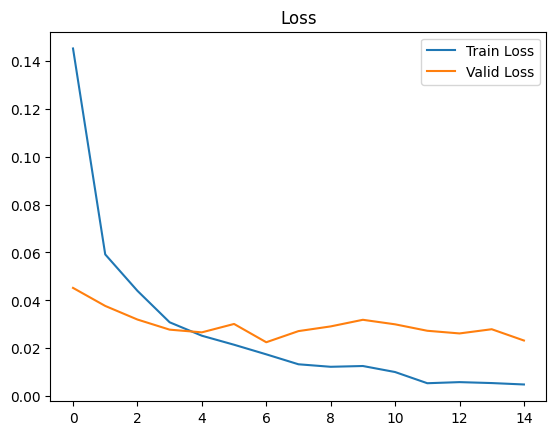

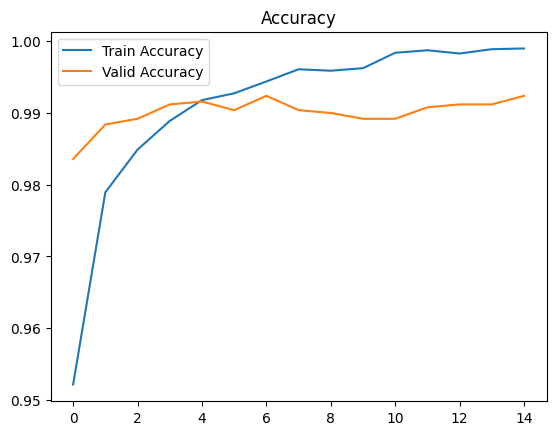

In [38]:
# 9. 모델 학습
fit(model, criterion, optimizer, epochs, train_loader, valid_loader)


In [39]:
import os
import torch
from datetime import datetime

# base 디렉토리 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리

# base 디렉토리 아래에 'model' 폴더 경로 설정
modelPath = os.path.join(base_dir, 'model')

# 폴더가 존재하지 않으면 생성
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

# 모델 파일 이름 설정
# selected_model_name에 .pth 확장자를 추가
selected_model_name = f"{selected_model_name}.pth" if not selected_model_name.endswith(".pth") else selected_model_name
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # 현재 시간 (년월일_시분초)

# 모델 저장
torch.save(model.state_dict(), os.path.join(modelPath, selected_model_name))

print(f"Model saved to {os.path.join(modelPath, selected_model_name)}_{current_time}")

Model saved to c:\Users\SBA\repository\yolo\model\efficientnet_b0.pth_20240930_210049


100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


['cat.11399.jpg', 'cat.11413.jpg', 'cat.11565.jpg', 'cat.11724.jpg', 'cat.11726.jpg', 'cat.11844.jpg', 'cat.12189.jpg', 'cat.12204.jpg', 'cat.12272.jpg', 'cat.12378.jpg', 'cat.12499.jpg', 'dog.11299.jpg', 'dog.11300.jpg', 'dog.11437.jpg', 'dog.11526.jpg', 'dog.11709.jpg', 'dog.11731.jpg', 'dog.12223.jpg', 'dog.12376.jpg']
test_correct:2481, test_total:2500
Test Loss: 0.0246, Test Accuracy: 99.24%


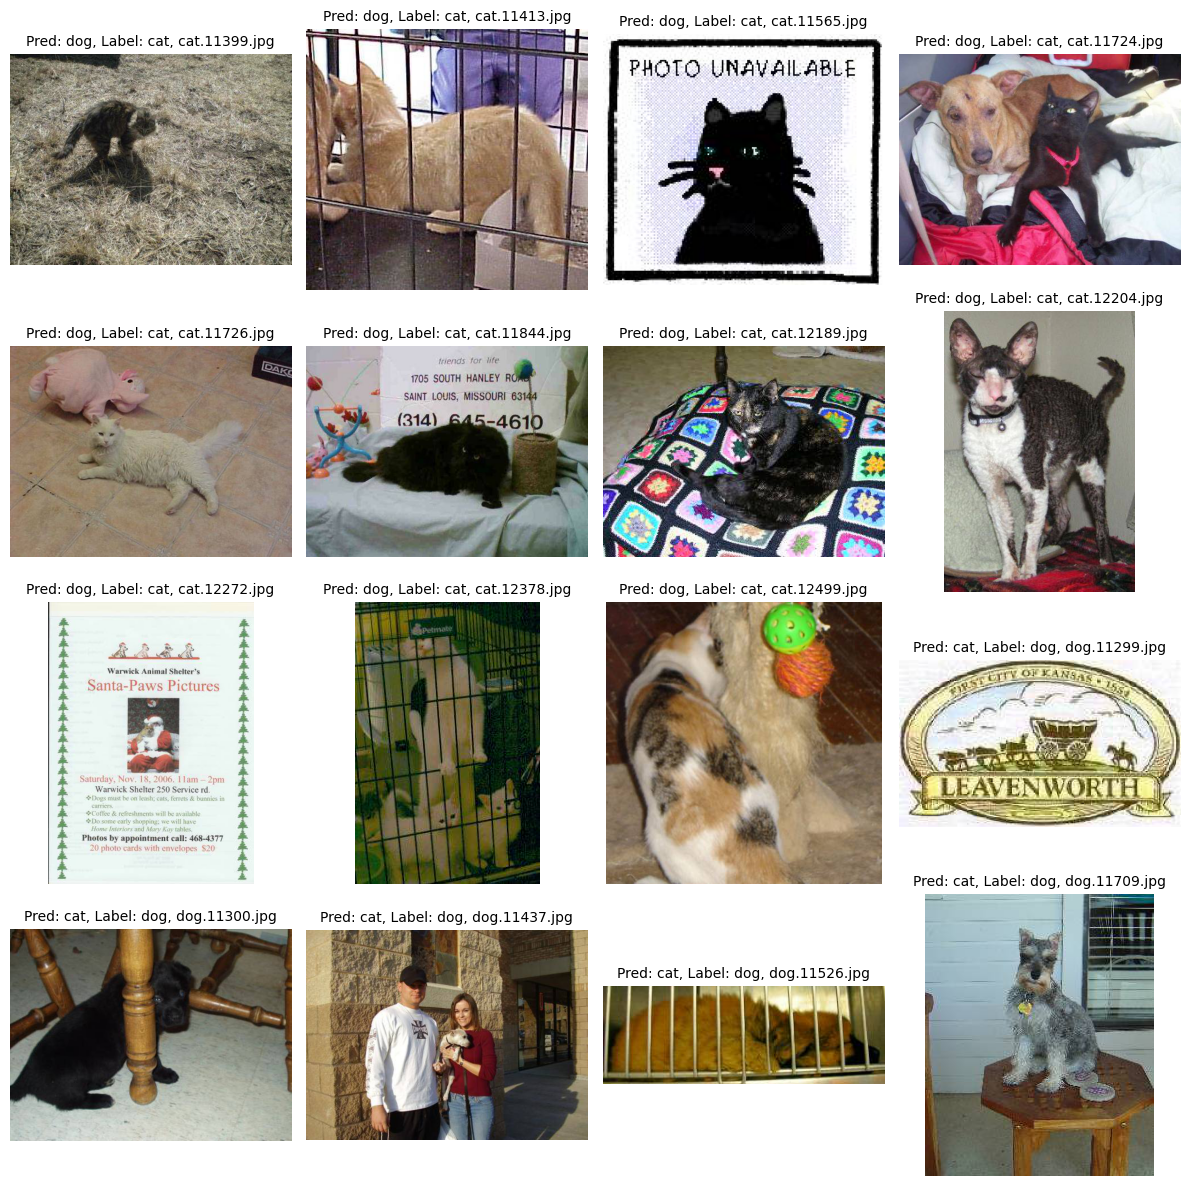

In [40]:
# 테스트 데이터를 통해 성능 평가 및 잘못된 예측 시각화
# 테스트 데이터에 레이블이 있는 경우
evaluate_and_visualize(model, test_loader, criterion)

In [41]:
# 레이블 없는 테스트 데이터에 대한 시각화 실행
# visualize_predictions(model, test_loader, device)